# INSTALACIÓN DE LIBRERÍAS

In [ ]:
# Descomprimir ZIP, extraer carpetas a road_dataset
!unzip -q /content/biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054.zip -d /content/road_dataset
# BIBLIOTECA SEGMENTATION MODELS
    # Incluye el modelo U-NET
!pip install segmentation-models-pytorch --quiet
# BIBLIOTECA ALBUMENTATIONS
    # Permite aplicar transformaciones a las imagenes
!pip install albumentations --quiet

replace /content/road_dataset/biankatpas-Cracks-and-Potholes-in-Road-Images-Dataset-1f20054/Dataset/1007599_RS_386_386RS289112_28920/1007599_RS_386_386RS289112_28920_CRACK.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Instalar librerias en el notebook/python
!{sys.executable} -m pip install opencv-python  # openCV
!{sys.executable} -m pip install torch torchvision torchaudio   # Torch, para redes neuronales
!{sys.executable} -m pip install segmentation-models-pytorch    # para arquitecturas de segmentacion

In [ ]:
%pip install albumentations # en caso el anterior install no funcione

  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached pydantic-2.11.7-py3-none-any.whl.metadata (67 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)
Using cached pydantic-2.11.7-py3-none-any.whl (444 kB)
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Librerias clave
import sys
import os
import glob
import cv2
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import json
import shutil

c:\Users\Fabrizio\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PREPARACIÓN PREVIO ENTRENAMIENTO

Análisis del conjunto de datos

In [2]:
# Ruta origen que contiene todas las subcarpetas de imagenes
root_dir = "./DatasetRoads"

# Contadores
total_imagenes = 0
con_pothole = 0
con_crack = 0
con_ambos = 0

# Recorre los nombres de las carpetas
for d in os.listdir(root_dir):
    # folder_path es la ruta de la carpeta actual
    folder_path = os.path.join(root_dir, d)
    # asegurar carpeta
    if not os.path.isdir(folder_path):
        continue
    # Busca las imagenes de mascara Crack y Pothole
    pothole_path = glob.glob(os.path.join(folder_path, f"{d}_POTHOLE.*"))
    crack_path   = glob.glob(os.path.join(folder_path, f"{d}_CRACK.*"))
    # si no hay alguna de las imagenes, lo obvia
    if not pothole_path or not crack_path:
        continue
    
    total_imagenes += 1
    has_pothole = False
    has_crack = False

    # Leer y verificar si máscara de pothole posee un pothole (almenos 1 pixel blanco)
    pothole_mask = cv2.imread(pothole_path[0], cv2.IMREAD_GRAYSCALE)
    if pothole_mask is not None and np.any(pothole_mask > 0):
        has_pothole = True

    # Leer y verificar si máscara de crack posee un crack (almenos 1 pixel blanco)
    crack_mask = cv2.imread(crack_path[0], cv2.IMREAD_GRAYSCALE)
    if crack_mask is not None and np.any(crack_mask > 0):
        has_crack = True
    # actualizar contadores
    if has_pothole:
        con_pothole += 1
    if has_crack:
        con_crack += 1
    if has_pothole and has_crack:
        con_ambos += 1

# Resultados
print("******************** Resultados ********************")
print(f"Total de conjuntos de imágenes: {total_imagenes}")
print(f"Con potholes: {con_pothole}")
print(f"Con cracks: {con_crack}")
print(f"Con ambos: {con_ambos}")

******************** Resultados ********************
Total de conjuntos de imágenes: 2235
Con potholes: 564
Con cracks: 1921
Con ambos: 252


Existen más imágenes con grietas (cracks) que imágenes con baches (pothole).
Esto puede generar problemas durante el entrenamiento por desbalance en los datos. Por ello, posteriormente se realizará un balance en las imágenes de entrenamiento a fin de maximizar los resultados.

Clase para cargar imágenes a partir de un dataset

(permite seleccionar imagenes del dataset y transformar las imágenes)

In [3]:
# Clase diseñada para cargar imagenes bajo ciertos argumentos
class RoadAnomalyDataset(Dataset):
    # se toma en cuenta que hay menos mascaras con pot_hole que con cracks
        # max_cracks sirve para balancear mascaras pothole y crack
    def __init__(self, root_dir, transform=None, max_cracks=con_pothole):
        self.root_dir = root_dir    # ruta origen
        self.transform = transform  # cargar funcion transform
        self.subfolders = []
        # contadores
        self.pothole_count = 0
        self.crack_count = 0
        self.ambos_count = 0

        pothole_folders = []    # guardar potholes
        crack_only_folders = [] # guardar cracks
        # recorrer subcarpetas de imagenes
        for d in os.listdir(root_dir):
            # cargar carpeta de imagen
            folder_path = os.path.join(root_dir, d)
            if not os.path.isdir(folder_path):  # existe carpeta
                continue
            # guardar rutas de mascaras
            pothole_path = glob.glob(os.path.join(folder_path, f"{d}_POTHOLE.*"))
            crack_path   = glob.glob(os.path.join(folder_path, f"{d}_CRACK.*"))
            if not pothole_path or not crack_path:  # existe crack o pothole
                continue
            # cargar imagenes de mascaras
            p_mask = cv2.imread(pothole_path[0], cv2.IMREAD_GRAYSCALE)
            c_mask = cv2.imread(crack_path[0], cv2.IMREAD_GRAYSCALE)
            # obviar si no existe mascara
            if p_mask is None or c_mask is None:
                continue
            # umbralizar mascara
                # las mascaras ya estan umbralizadas, esto es un seguro
            has_pothole = np.any(p_mask > 127)
            has_crack   = np.any(c_mask > 127)
            # Considerando que hay menos pothole que cracks
            if has_pothole:
                # si hay pothole, lo agrega
                pothole_folders.append(folder_path)
                self.pothole_count += 1
                # si tambien hay crack, se aumenta contador
                if has_crack:
                    self.ambos_count += 1 # imagen con ambas
                    self.crack_count += 1
            # si hay crack y no supera max_cracks
            elif has_crack and (self.crack_count < max_cracks):
                # guardar imagen
                crack_only_folders.append(folder_path)
                self.crack_count += 1

        # Añadir todos los que tienen potholes (con o sin crack)
        self.subfolders.extend(pothole_folders)

        # Añadir todos los que solo tengan cracks (balanceado)
        selected_cracks = crack_only_folders[:max_cracks]
        self.subfolders.extend(selected_cracks)
        # Imprimir resultados
        print(f"Dataset balanceado cargado:")
        print(f"Imágenes con potholes: {self.pothole_count - self.ambos_count}")
        print(f"Imágenes con cracks: {len(selected_cracks)}")
        print(f"Imágenes con ambos: {self.ambos_count}")
        print(f"Total seleccionado: {len(self.subfolders)}")
    # Verificar si existe imagen
    def find_image(self, folder_path, pattern):
        matches = glob.glob(os.path.join(folder_path, f"{pattern}.*"))
        if not matches:
            raise FileNotFoundError(f"No se encontró archivo con patrón: {pattern}.* en {folder_path}")
        return matches[0]
    # tamaño
    def __len__(self):
        return len(self.subfolders)
    # cargar imagen y aplicar transformaciones
    def __getitem__(self, idx):
        # cargar ruta carpeta
        folder_path = self.subfolders[idx]
        folder_name = os.path.basename(folder_path)
        # rutas de las imagenes
        img_path     = self.find_image(folder_path, f"{folder_name}_RAW")
        pothole_path = self.find_image(folder_path, f"{folder_name}_POTHOLE")
        crack_path   = self.find_image(folder_path, f"{folder_name}_CRACK")
        # cargar imagen
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # cargar mascaras
        pothole_mask = cv2.imread(pothole_path, 0)
        crack_mask   = cv2.imread(crack_path, 0)
        # crear mascara vinaria
        mask = np.stack([
            (pothole_mask > 127).astype(np.uint8),
            (crack_mask > 127).astype(np.uint8)
        ], axis=-1)
        # aplicar transformaciones a la imagen
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            return augmented['image'], augmented['mask'].float()

Crear transformación personalizada.

Se realiza la carga de las imágenes del dataset según la transformación

In [4]:
# Transformacion personalizada
transform = A.Compose([
    A.Resize(640, 1024, interpolation=cv2.INTER_NEAREST),   # resize, evita interpolacion
    A.HorizontalFlip(p=0.5),    # inversion horizontal
    A.RandomBrightnessContrast(p=0.2),  # ajustar aleatoriamente el brillo
    A.GaussianBlur(p=0.1),  # aplicar desenfoque
    A.ElasticTransform(p=0.1, interpolation=cv2.INTER_NEAREST),  # deformar elasticamente, evita interpolacion
    A.Normalize(), # normalizar
    ToTensorV2()    # convertir a tensor Pytorch
])

# Ruta origen
dataset_path = './DatasetRoads'

# Cargar dataset aplicando TRANSFORM a cada imagen
dataset = RoadAnomalyDataset(dataset_path, transform=transform, max_cracks=con_pothole)

Dataset balanceado cargado:
Imágenes con potholes: 312
Imágenes con cracks: 441
Imágenes con ambos: 252
Total seleccionado: 1005


Seleccionar GPU para mejorar rendimiento

In [5]:
# Usar GPU
print("¿CUDA disponible?:", torch.cuda.is_available())
print("GPU detectada:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")

¿CUDA disponible?: True
GPU detectada: NVIDIA GeForce RTX 3050 Laptop GPU
Dispositivo: cuda


# SEPARAR DATASET (TRAIN Y TEST)

Separar dataset de entrenamiento (train) y prueba (test).

Genera los cargadores de datos con parámetros ajustados a mi PC/GPU.

In [6]:
# 80% entrenamiento, 20% prueba
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
# devision aleatoria
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Cargador de datos - parametros
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # data
    batch_size=2,   # tamaño lote / se ajusta segun capacidad del GPU
    shuffle=True,   # aleatorio
    num_workers=0
    )
test_loader  = torch.utils.data.DataLoader(
    test_dataset,   # data
    batch_size=1,   # lote
    shuffle=False, 
    num_workers=0
    )

# Guardar índices en disco
train_indices = train_dataset.indices
test_indices = test_dataset.indices
# Usar JSON por si acaso
with open('train_indices.json', 'w') as f:
    json.dump(train_indices, f)
with open('test_indices.json', 'w') as f:
    json.dump(test_indices, f)

Se arma un código para guardar las imágenes en subcarpetas de train y test basándose en los índices guardados.

**Solo correr este codigo una vez**

In [7]:
# Lista de subcarpetas completas
all_folders = dataset.subfolders  # ← importante que `dataset` sea el original

# Carpetas destino
destino_ROOT = './Dataset_final'
train_DIR = os.path.join(destino_ROOT, 'train')
test_DIR  = os.path.join(destino_ROOT, 'test')
os.makedirs(train_DIR, exist_ok=True)
os.makedirs(test_DIR, exist_ok=True)

# Función para copiar subcarpetas
def copiar_subcarpetas(indices, destino):
    for idx in indices:
        carpeta_origen = all_folders[idx]
        nombre = os.path.basename(carpeta_origen)
        carpeta_destino = os.path.join(destino, nombre)
        shutil.copytree(carpeta_origen, carpeta_destino, dirs_exist_ok=True)

# Copiar subcarpetas
copiar_subcarpetas(train_indices, train_DIR)
copiar_subcarpetas(test_indices, test_DIR)

print("Copia completada.")

Copia completada.


Este código sirve para cargar las imágenes previamente ya seleccionadas y guardadas en la subcarpeta Dataset_final.
Sirve para que el proyecto sea reproducible hasta cierto punto y evita tener que cargar todo el dataset inicial.

In [32]:
def cargar_datasets(transform=None):
    from torch.utils.data import Dataset

    # Ruta base
    destino_ROOT = './Dataset_final'
    train_dir = os.path.join(destino_ROOT, 'train')
    test_dir  = os.path.join(destino_ROOT, 'test')

    # Cargar datasets desde esas carpetas
        # valot alto de max_cracks para aceptar todas las imagenes
    train_dataset = RoadAnomalyDataset(train_dir, transform=transform, max_cracks=10000)
    test_dataset  = RoadAnomalyDataset(test_dir,  transform=transform, max_cracks=10000)

    return train_dataset, test_dataset

# Cargar dataset ya transformados
train_dataset, test_dataset = cargar_datasets(transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset,  # data
    batch_size=2,   # tamaño lote / se ajusta segun capacidad del GPU
    shuffle=True,   # aleatorio
    num_workers=0
    )
test_loader  = torch.utils.data.DataLoader(
    test_dataset,   # data
    batch_size=1,   # lote
    shuffle=False, 
    num_workers=0
    )

Dataset balanceado cargado:
Imágenes con potholes: 247
Imágenes con cracks: 359
Imágenes con ambos: 198
Total seleccionado: 804
Dataset balanceado cargado:
Imágenes con potholes: 65
Imágenes con cracks: 82
Imágenes con ambos: 54
Total seleccionado: 201


# METODOS PARA EVALUAR EL ENTRENAMIENTO

Clase pérdida para verificar el rendimiento del entrenamiento.

Usa:
 - BCE (binary cross entropy)
    - Mide diferencia entre prob predicha y mascara real por pixel
 - DICE
    - Mide superposicion de mascaras

In [8]:
# Clase perdida
class BCEDiceLoss(nn.Module):
    # constructor, le da pesos de importancia a cada clase
    def __init__(self, crack_weight=1.0, pothole_weight=1.0):
        super().__init__()
        self.crack_weight = crack_weight
        self.pothole_weight = pothole_weight
    # calculo de perdida
    def forward(self, pred, target):
        # pred y target forma: [B, 2, H, W]
        pred = torch.sigmoid(pred)  # convierte logits  en probs
        smooth = 1.0

        losses = []
        # bce: binary cross entropy
            # mide diferencia entre prob predicha y mascara real por pixel
        # dice
            # mide superposicion de mascaras
        for i in range(2):  # Clase 0: pothole, Clase 1: crack
            bce = F.binary_cross_entropy(pred[:, i], target[:, i])  # perdida BCE
            intersection = (pred[:, i] * target[:, i]).sum(dim=(1, 2))
                # calcula la interseccion entre prediccion y real
            union = pred[:, i].sum(dim=(1, 2)) + target[:, i].sum(dim=(1, 2))
                # calcula la union entre prediccion y real
            dice = (2. * intersection + smooth) / (union + smooth)
                # coeficiente DICE
            dice_loss = 1 - dice.mean() # perdida DICE

            total = bce + dice_loss # combinar pedidas
            weight = self.pothole_weight if i == 0 else self.crack_weight
            # usar los pesos de perdida
            losses.append(weight * total)   # calcula perdidas en base a pesos

        return sum(losses)
    
# Darle el doble de importancia a los cracks:
loss_fn = BCEDiceLoss(crack_weight=2.0, pothole_weight=1.0)

Función de evaluación de rendimiento por pérdidas

- Obtiene la perdida acumulada promedio por lote. Sirve para seleccionar el mejor modelo en base a perdida BCEDiceLoss.

In [9]:
# Funcion de evaluacion de rendimiento
def evaluate(model, loader):
    model.eval()    # modelo modo evaluacion
    total_loss = 0.0    # acumular perdida
    with torch.no_grad():   # no requiere backward durante evaluacion
        for imgs, masks in loader:      # itera imagenes y mascaras
            imgs, masks = imgs.to(device), masks.to(device) # GPU
            masks = masks.permute(0, 3, 1, 2)  # De [B, H, W, C] a [B, C, H, W]
                # Tensor debe coincidir con la salida del modelo
            preds = model(imgs)
            loss = loss_fn(preds, masks)    # aplica funcion de perdida
            total_loss += loss.item()   # acumular
    return total_loss / len(loader) # perdida promedio por lote

Evaluación por IoU
- Mide cuánto se solapa/superponen la prediccion con la mascara real. Valor muy útil para segmentación semántica.

In [10]:
# Calcular IoU - Util para segmentacion semantica
def iou_score(preds, targets, threshold=0.3):
    preds = torch.sigmoid(preds)    # predicciones
    preds = (preds > threshold).float() # umbral para considerar un pixel positivo

    ious = []   # almacenar IoU de cada clase
    for c in range(preds.shape[1]): # itera sobre clases
        pred = preds[:, c]  # predicciones
        target = targets[:, c]  # mascaras reales
        intersection = (pred * target).sum(dim=(1, 2)) # medir interseccion
        union = pred.sum(dim=(1, 2)) + target.sum(dim=(1, 2)) - intersection + 1e-6 # medir union
        iou = (intersection + 1e-6) / union # calculo IoU
        ious.append(iou.mean().item())  # calcular promedio por lote

    return ious  # Lista con IoU por clase

In [11]:
# Calcular IoU promedio por clase para todo el modelo
def evaluate_iou(model, loader):
    model.eval()    # modo evaluacion
    iou_potholes, iou_cracks = [], []   # IoU por clase

    with torch.no_grad():   # no backward
        for imgs, masks in loader:
            imgs = imgs.to(device)  # GPU
            masks = masks.permute(0, 3, 1, 2).to(device)    # re ordenar tensor 
            preds = model(imgs) # predicciones
            ious = iou_score(preds, masks)  # IoU por clase
            iou_potholes.append(ious[0])    # agregar a pothole
            iou_cracks.append(ious[1])  # agregar a crack

    return np.mean(iou_potholes), np.mean(iou_cracks)   # retornar promedios

Ajustar Modelo UNET y mejorar rapidez del entrenamiento

In [12]:
torch.backends.cudnn.benchmark = True
# acelera el entrenamiento / solo usar si las imagenes tienen mismo tamaño

In [13]:
model = smp.Unet(
    encoder_name='resnet18',        # encoder más ligero
    encoder_weights='imagenet',     # pesos preentrenados
    in_channels=3,                  # imagenes RGB
    classes=2                       # 2 clases: potholes y cracks
).to(device)    # GPU

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizador ADAM, ajusta tasa de aprendizaje

# ENTRENAMIENTO

In [14]:
n_epochs = 100  # epocas
history = []    # historial, resultados de metricas
best_test_loss = float('inf')         # Mejor perdida de validacion
best_mean_iou = 0.0                   # Mejor IoU promedio

for epoch in range(n_epochs):
    model.train()   # modo entrenamiento
    epoch_loss = 0  # acumulador de perdida
    #   Mostrar barra de progreso en la iteracion por lote
    loop = tqdm(train_loader, desc=f"! Epoch {epoch+1}/{n_epochs}", file=sys.stdout)
    for imgs, masks in loop:
        # mover imagenes y mascaras a GPU
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        masks = masks.permute(0, 3, 1, 2)  # [B, H, W, 2] -> [B, 2, H, W]
        optimizer.zero_grad()
        preds = model(imgs) # prediccion
    
        loss = loss_fn(preds, masks)    # perdida
        loss.backward() # backpropagation
        optimizer.step()    # updt pesos
        epoch_loss += loss.item()   # acumular perdida
        loop.set_postfix({"Batch Loss": loss.item()})

    avg_train_loss = epoch_loss / len(train_loader) # perdida acumulada promedio de TRAIN
    test_loss = evaluate(model, test_loader)    # perdida de TEST
    print(f"🌱 Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f} | Test Loss: {test_loss:.4f}")
    # Calculo de IoU para pothole  y  crack
    iou_pothole, iou_crack = evaluate_iou(model, test_loader)
    print(f"IoU Pothole: {iou_pothole:.4f} | IoU Crack: {iou_crack:.4f}")

    mean_iou = (iou_pothole + iou_crack) / 2    # perdida IoU promedio

    # Guardar historial
    history.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'test_loss': test_loss,
        'iou_pothole': iou_pothole,
        'iou_crack': iou_crack
    })

    if epoch % 2 == 0:
        model.eval()
        with torch.no_grad():
            img, mask = test_dataset[0]
            img_tensor = img.unsqueeze(0).to(device)
            pred = torch.sigmoid(model(img_tensor)).squeeze().cpu().numpy()

    # Guardar checkpoint general
    #torch.save({
    #    'epoch': epoch,
    #    'model_state_dict': model.state_dict(),
    #    'optimizer_state_dict': optimizer.state_dict(),
    #}, 'checkpoint.pth')

    # Guardar mejor modelo por Test Loss
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save({
            'model_state_dict': model.state_dict(), # pesos
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'history': history  # guardar historial
        }, 'best_model_loss.pth')
        print(f"✅ Mejor modelo Loss actualizado (Test Loss: {best_test_loss:.4f})")

    # Guardar mejor modelo por IoU promedio
    if mean_iou > best_mean_iou:
        best_mean_iou = mean_iou
        torch.save({
            'model_state_dict': model.state_dict(), #pesos
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'history': history  # guardar historial
        }, 'best_model_iou.pth')
        print(f"✅ Mejor modelo IoU actualizado (IoU Promedio: {best_mean_iou:.4f})")

# Mostrar historial
print("\n***** Resultados por época: *****")
for entry in history:
    print(f"+++ Epoch {entry['epoch']}: "
          f"Train Loss = {entry['train_loss']:.4f} | "
          f"Test Loss = {entry['test_loss']:.4f} | "
          f"IoU Pothole = {entry['iou_pothole']:.4f} | "
          f"IoU Crack = {entry['iou_crack']:.4f}")

! Epoch 1/100: 100%|██████████| 402/402 [02:07<00:00,  3.16it/s, Batch Loss=3.22]
🌱 Epoch 1/100 - Train Loss: 3.6608 | Test Loss: 3.2391
IoU Pothole: 0.1298 | IoU Crack: 0.1428
✅ Mejor modelo Loss actualizado (Test Loss: 3.2391)
✅ Mejor modelo IoU actualizado (IoU Promedio: 0.1363)
! Epoch 2/100: 100%|██████████| 402/402 [01:58<00:00,  3.39it/s, Batch Loss=2.75]
🌱 Epoch 2/100 - Train Loss: 2.9397 | Test Loss: 2.7605
IoU Pothole: 0.1980 | IoU Crack: 0.2358
✅ Mejor modelo Loss actualizado (Test Loss: 2.7605)
✅ Mejor modelo IoU actualizado (IoU Promedio: 0.2169)
! Epoch 3/100: 100%|██████████| 402/402 [01:59<00:00,  3.37it/s, Batch Loss=2.37]
🌱 Epoch 3/100 - Train Loss: 2.5184 | Test Loss: 2.4115
IoU Pothole: 0.2210 | IoU Crack: 0.2319
✅ Mejor modelo Loss actualizado (Test Loss: 2.4115)
✅ Mejor modelo IoU actualizado (IoU Promedio: 0.2265)
! Epoch 4/100: 100%|██████████| 402/402 [02:00<00:00,  3.35it/s, Batch Loss=2.46]
🌱 Epoch 4/100 - Train Loss: 2.2234 | Test Loss: 2.1761
IoU Pothole: 0

# MOSTRAR RESULTADOS DEL MODELO
Se genera una función que prediga CRACKS y POTHOLES basandose en 2 modelos. El primer modelo es el que dió una mayor puntuación promedio de IoU. El segundo es el que dió un menor TestLoss durante el entrenamiento.

In [15]:
def visualizar_prediccion(model_path1, model_path2, dataset, index, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Cargar modelo (se usa el mismo modelo siempre)
    def predecir(model_path, sample_img_batch):
        model = smp.Unet(
            encoder_name='resnet18',
            encoder_weights='imagenet',
            in_channels=3,
            classes=2
        ).to(device)    # GPU
        # cargar el modelo 1 seleccionado
        state = torch.load(model_path, map_location=device, weights_only=False)
        if isinstance(state, dict) and 'model_state_dict' in state:
            state = state['model_state_dict']   # extraer solo los pesos
        model.load_state_dict(state)
        model.eval()    # evaluacion

        # Obtener imagen y mascara
        with torch.no_grad():
            # Prediccion
            pred_mask = model(sample_img_batch) # prediccion
            pred_mask = torch.sigmoid(pred_mask).squeeze().cpu().numpy()
        return pred_mask


    # Obtener imagen y mascara del dataset
    sample_img, sample_mask = dataset[index]
    sample_img_batch = sample_img.unsqueeze(0).to(device)   # GPU

    # Obtener predicciones de ambos modelos
    pred_mask1 = predecir(model_path1, sample_img_batch)
    pred_mask2 = predecir(model_path2, sample_img_batch)

    # Preparar datos para visualización
    sample_img_np = sample_img.permute(1, 2, 0).cpu().numpy()
    sample_mask_np = sample_mask.cpu().numpy()

    # Mostrar conteo de píxeles
    print(f"Pixeles positivos en Pothole: {np.sum(sample_mask_np[..., 0])}")
    print(f"Pixeles positivos en Crack:   {np.sum(sample_mask_np[..., 1])}")

    # Visualización
    plt.figure(figsize=(20, 10))
    # img original
    plt.subplot(2, 4, 1)
    plt.imshow(sample_img_np)
    plt.title("Imagen Original")
    plt.axis('off')
    # mascara real Pothole
    plt.subplot(2, 4, 2)
    plt.imshow(sample_mask_np[..., 0], cmap='gray')
    plt.title("Mascara: Pothole")
    plt.axis('off')
    # prediccion pothole 1
    plt.subplot(2, 4, 3)
    plt.imshow((pred_mask1[0] > 0.5), cmap='gray')
    plt.title("Prediccion pothole - Mejor IoU")
    plt.axis('off')
   # prediccion pothole 2
    plt.subplot(2, 4, 4)
    plt.imshow((pred_mask2[0] > 0.5), cmap='gray')
    plt.title("Prediccion pothole - Mejor TestLoss")
    plt.axis('off')
    # imagen original x2
    plt.subplot(2, 4, 5)
    plt.imshow(sample_img_np)
    plt.title("Imagen Original")
    plt.axis('off')
    # mascara real Crack
    plt.subplot(2, 4, 6)
    plt.imshow(sample_mask_np[..., 1], cmap='gray')
    plt.title("Mascara: Crack")
    plt.axis('off')
    # prediccion crack 1
    plt.subplot(2, 4, 7)
    plt.imshow((pred_mask1[1] > 0.5), cmap='gray')
    plt.title("Predicción Crack - Mejor IoU")
    plt.axis('off')
    # prediccion crack 2
    plt.subplot(2, 4, 8)
    plt.imshow((pred_mask2[1] > 0.5), cmap='gray')
    plt.title("Predicción Crack - Mejor TestLoss")
    plt.axis('off')
    # mostrar
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Pixeles positivos en Pothole: 0.0
Pixeles positivos en Crack:   2253.0


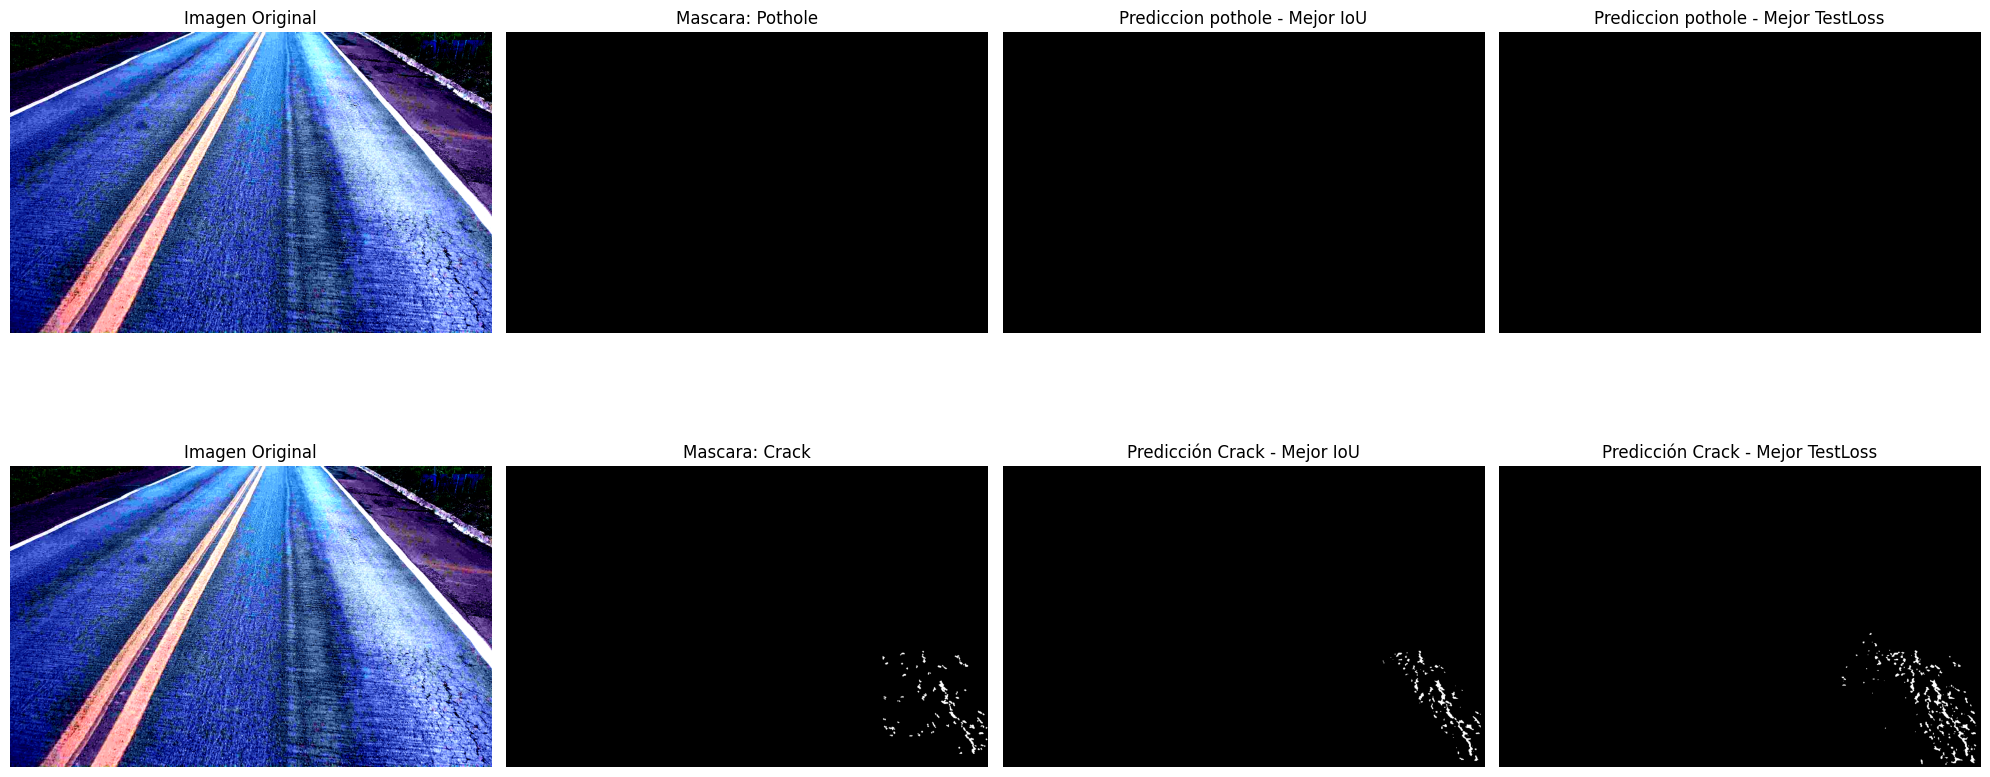

In [16]:
model_path1 = 'best_model_iou.pth'   # ruta modelo IoU
model_path2 = 'best_model_loss.pth' # ruta modelo TestLoss
# se usa Test_Dataset
visualizar_prediccion(model_path1=model_path1, model_path2=model_path2, dataset=test_dataset, index=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Pixeles positivos en Pothole: 2749.0
Pixeles positivos en Crack:   4918.0


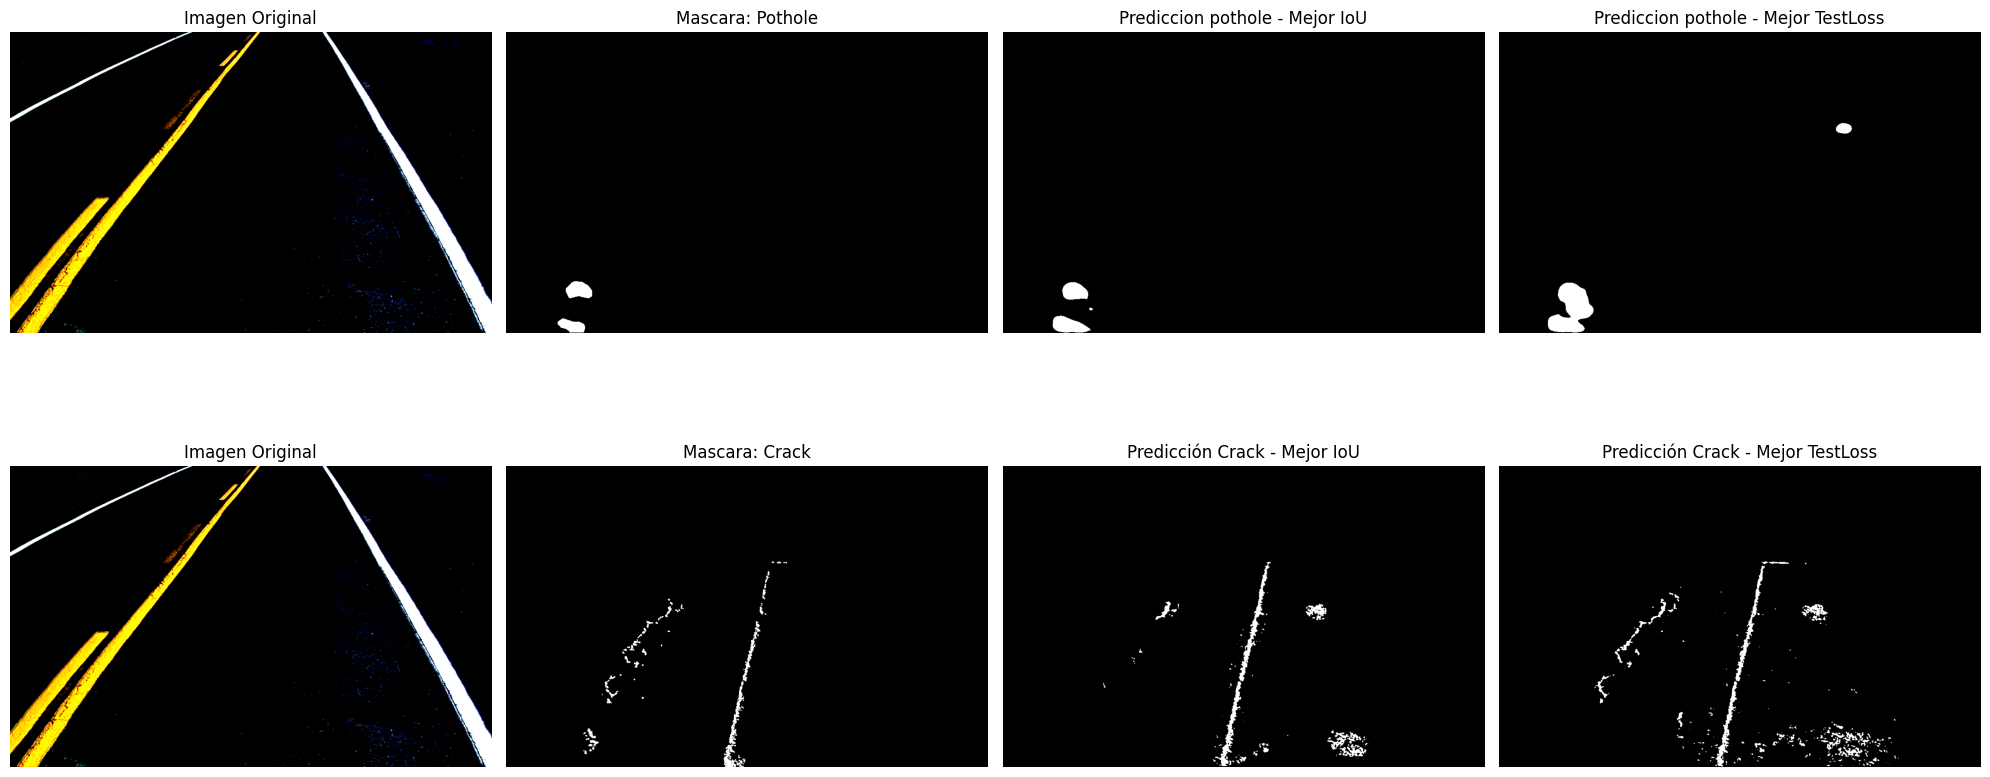

In [37]:
visualizar_prediccion(model_path1=model_path1, model_path2=model_path2, dataset=test_dataset, index=111)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Pixeles positivos en Pothole: 0.0
Pixeles positivos en Crack:   6728.0


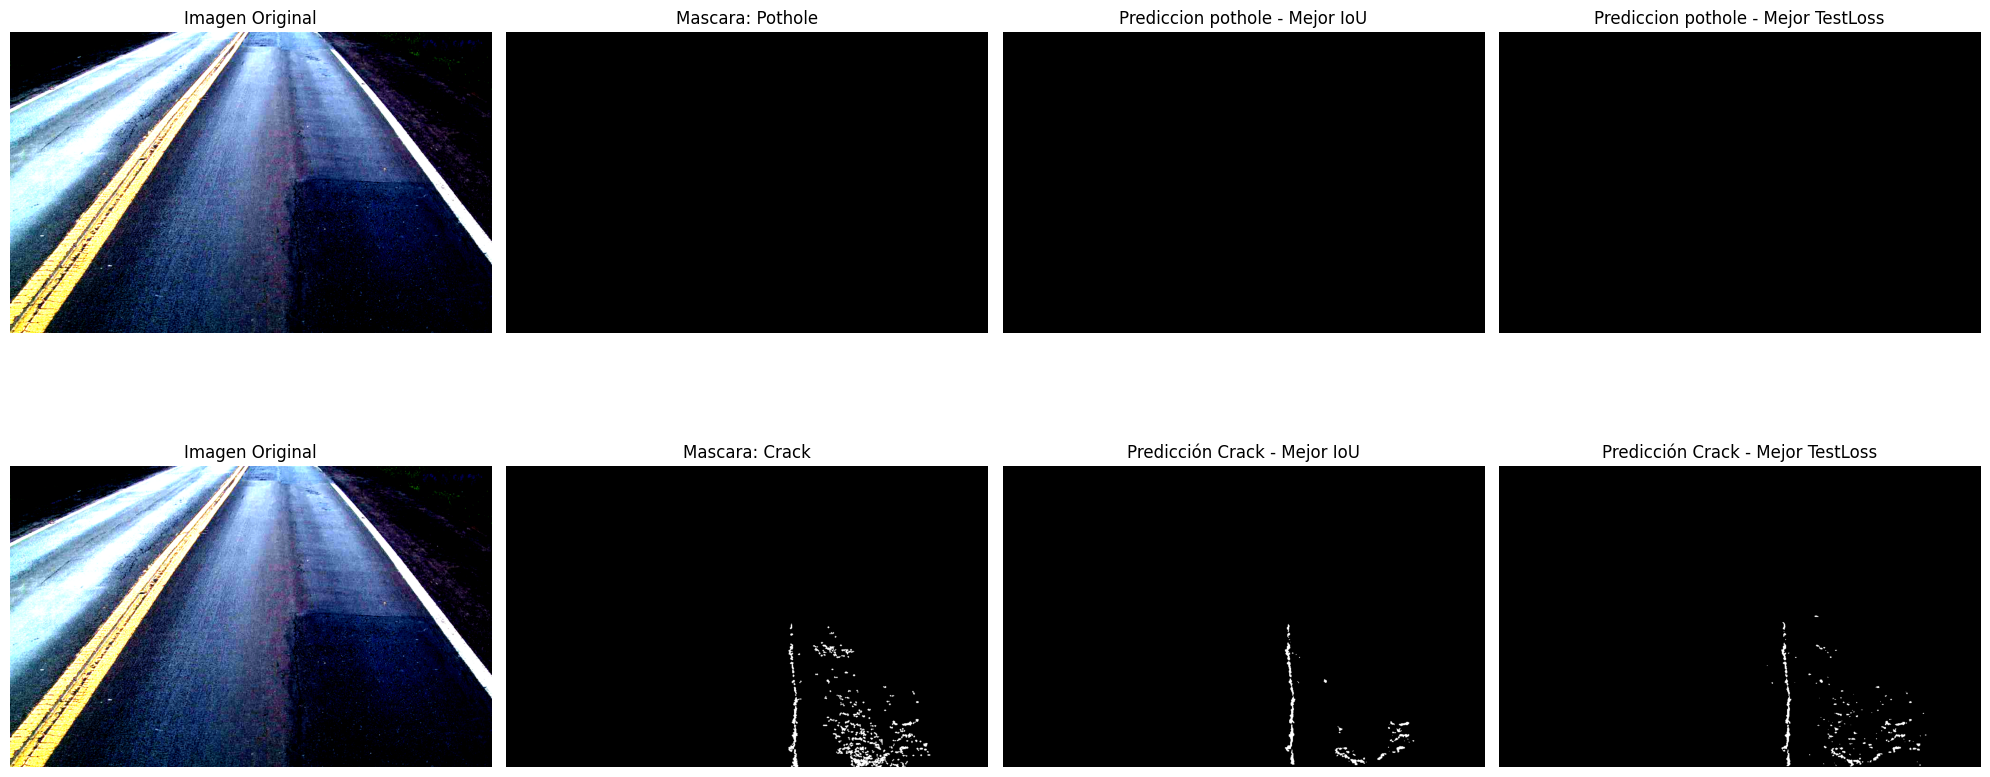

In [34]:
visualizar_prediccion(model_path1=model_path1, model_path2=model_path2, dataset=test_dataset, index=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


Pixeles positivos en Pothole: 2466.0
Pixeles positivos en Crack:   2075.0


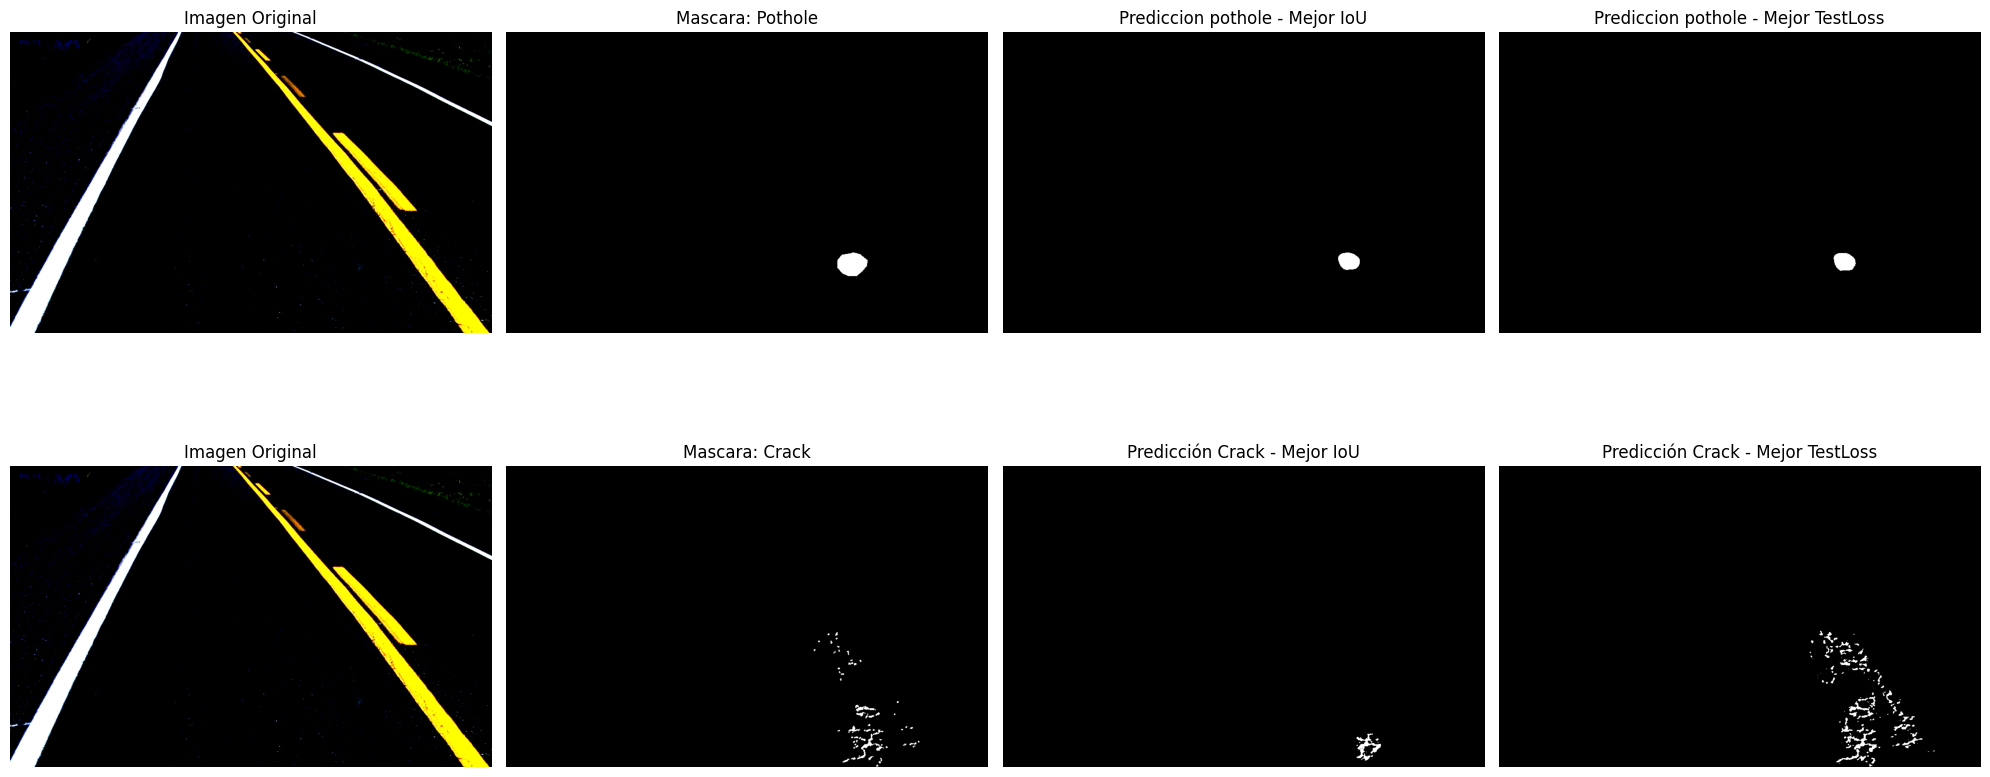

In [47]:
visualizar_prediccion(model_path1=model_path1, model_path2=model_path2, dataset=test_dataset, index=23)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6897851..2.6399999].


Pixeles positivos en Pothole: 3389.0
Pixeles positivos en Crack:   2415.0


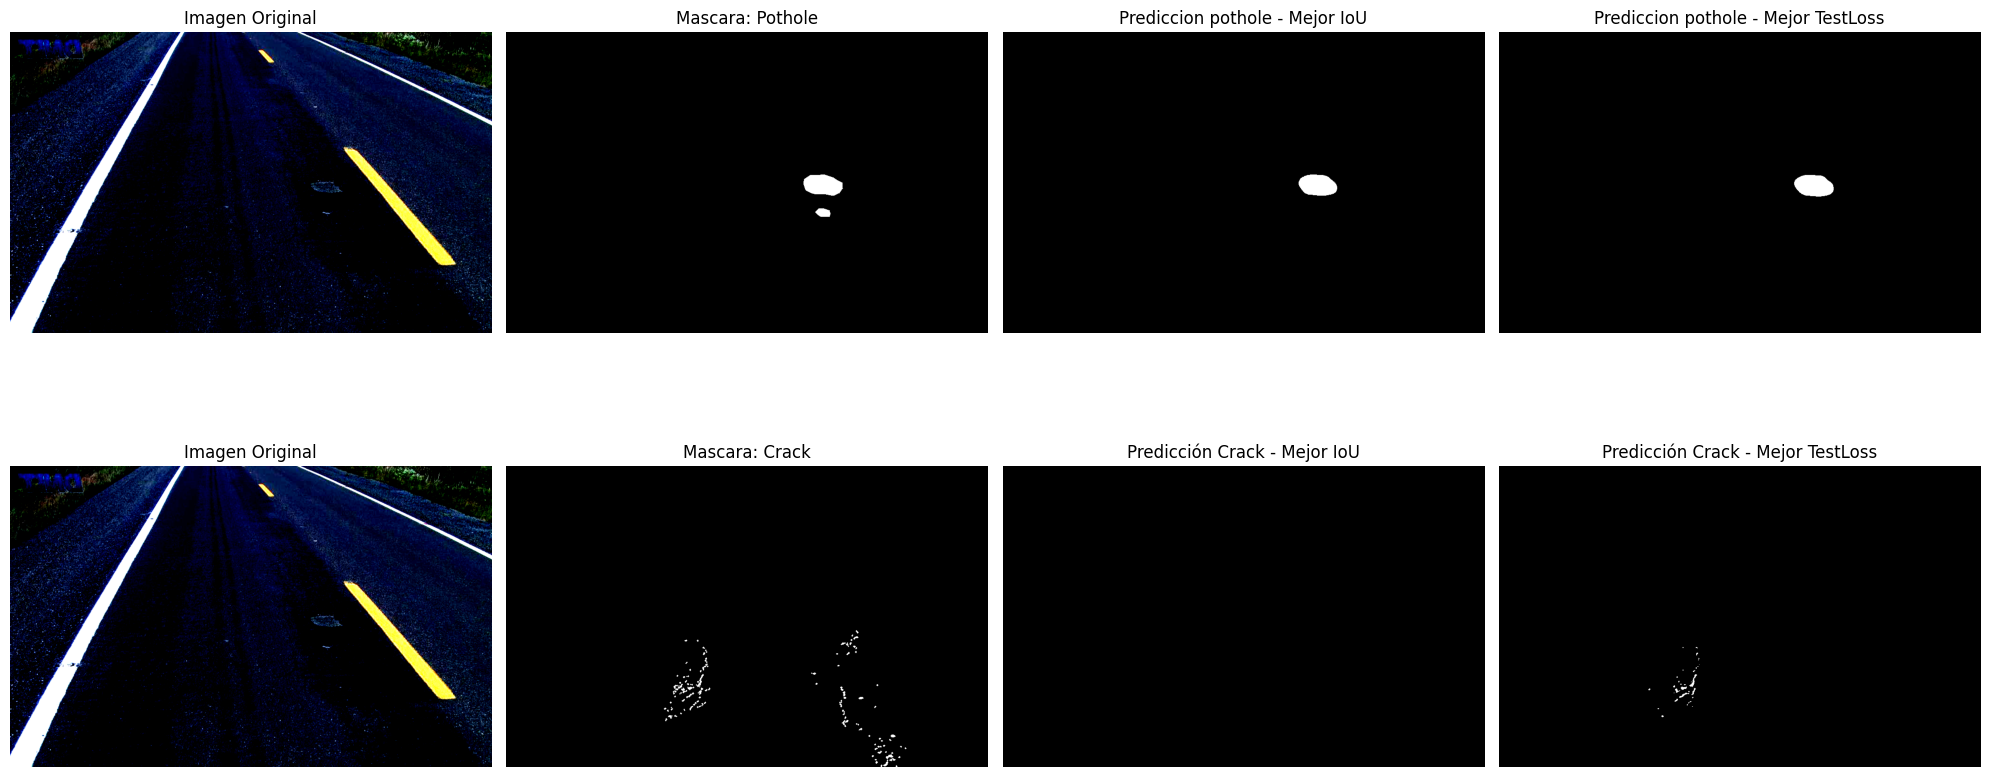

In [33]:
visualizar_prediccion(model_path1=model_path1, model_path2=model_path2, dataset=test_dataset, index=55)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9809059..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9809059..2.6399999].


Pixeles positivos en Pothole: 14452.0
Pixeles positivos en Crack:   0.0


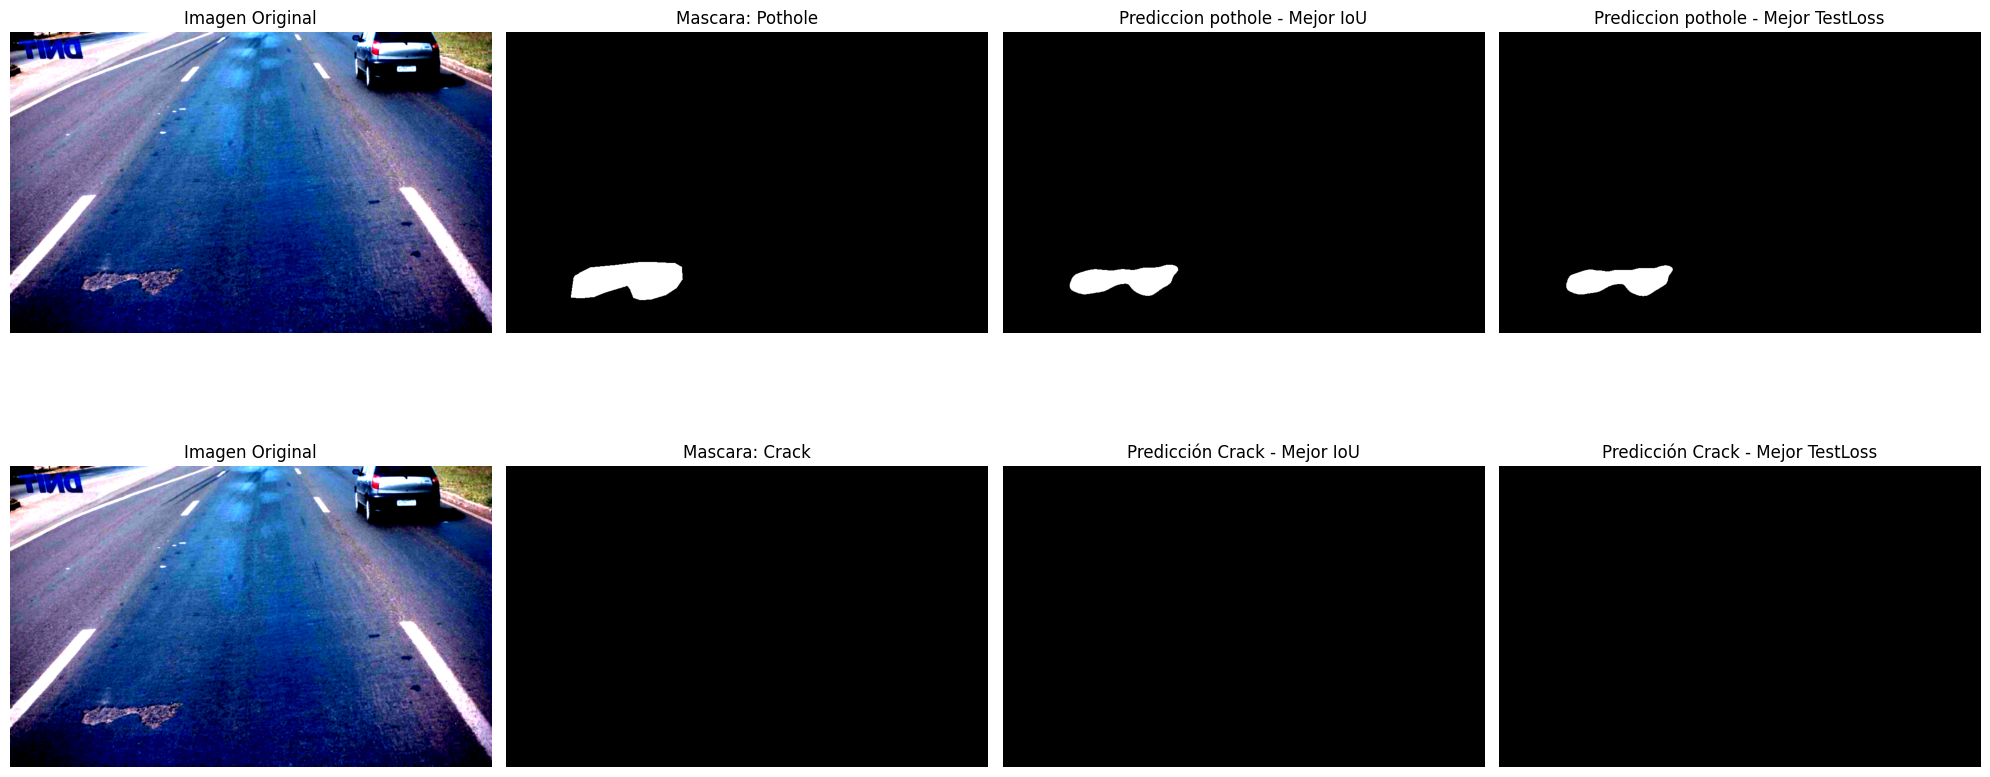

In [32]:
visualizar_prediccion(model_path1=model_path1, model_path2=model_path2, dataset=test_dataset, index=45)

# Gráfica de pérdida y puntuación IoU por época

Toda la información con respecto a ambos valores está almacenado dentro de history del modelo.

In [48]:
def mostrar_Graficas(history):
    # Extraer datos
    epochs = [h['epoch'] for h in history]
    train_losses = [h['train_loss'] for h in history]
    test_losses  = [h['test_loss'] for h in history]
    iou_potholes = [h['iou_pothole'] for h in history]
    iou_cracks   = [h['iou_crack'] for h in history]
    # Gráfica de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, test_losses, label='Test Loss', marker='x')
    plt.title("Perdida por Epoca")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    # Gráfica de IoU
    plt.subplot(1, 2, 2)
    plt.plot(epochs, iou_potholes, label='IoU Pothole', marker='o')
    plt.plot(epochs, iou_cracks, label='IoU Crack', marker='x')
    plt.title("IoU por Época")
    plt.xlabel("Época")
    plt.ylabel("IoU")
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    #Mostrar
    plt.tight_layout()
    plt.show()

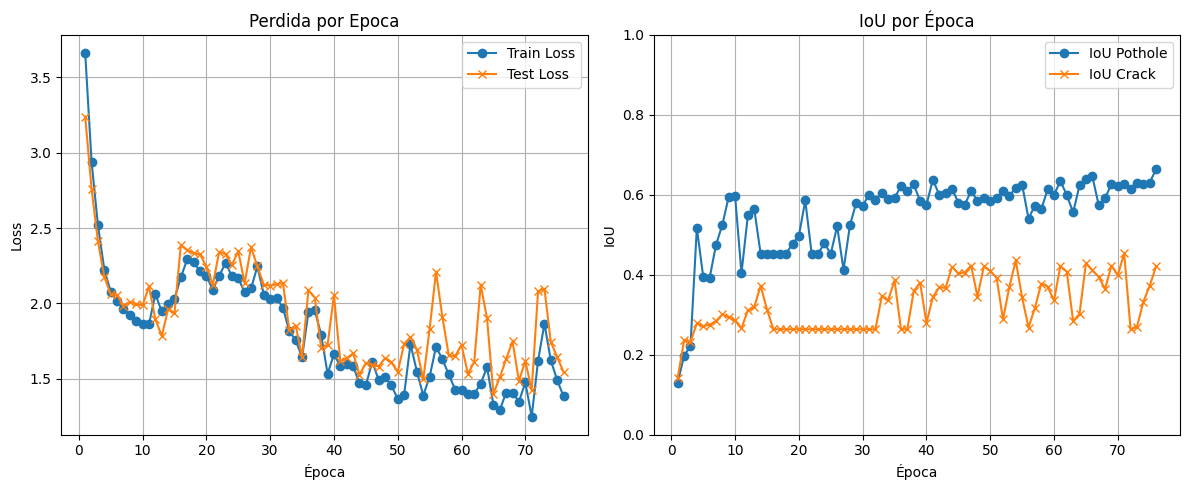

In [49]:
# cargar historia de best_model_iou
checkpoint1 = torch.load('best_model_iou.pth', map_location='cpu', weights_only=False)
history1 = checkpoint1['history']
mostrar_Graficas(history1)

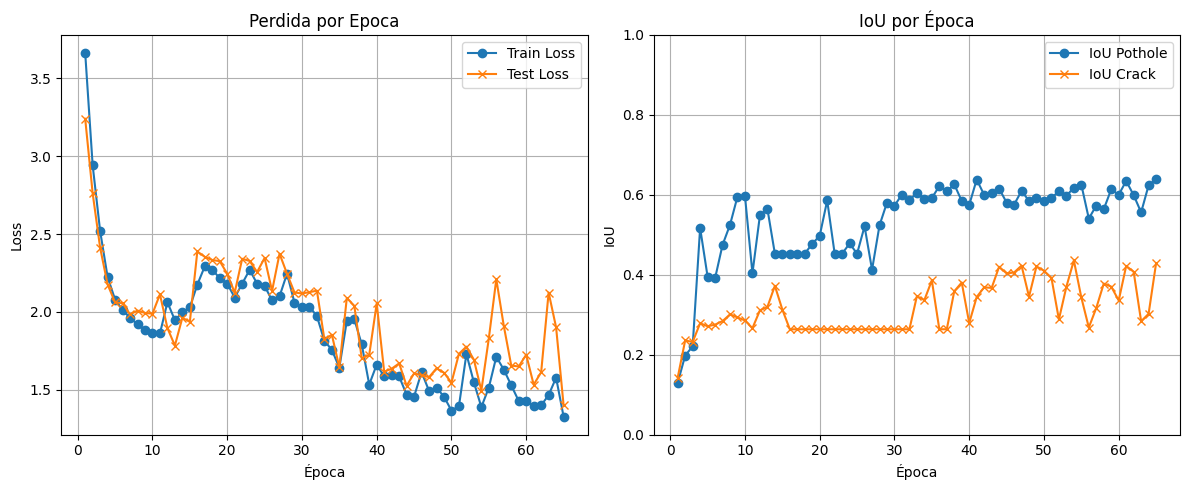

In [50]:
# cargar historia de best_model_loss
checkpoint2 = torch.load('best_model_loss.pth', map_location='cpu', weights_only=False)
history2 = checkpoint2['history']
mostrar_Graficas(history2)

In [51]:
# Guardar History
with open("history1.json", "w") as f:
    json.dump(history1, f)
with open("history2.json", "w") as f:
    json.dump(history2, f)

In [52]:
# Cargar history
with open("history1.json", "r") as f:
    history1 = json.load(f)
with open("history2.json", "r") as f:
    history2 = json.load(f)